In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

Import OSNIR Dataset and shuffle data

In [3]:
# import OSNIR dataset
df = pd.read_csv('../Data/OSNIR_values_extendedv3_new datasetbcsv.csv')
# shuffling rows of OSNIR dataframe and reset indexes
df = df.sample(frac=1)
df.reset_index(inplace=True, drop=True)

Preview of first 5 samples

In [4]:
df.head()

,OSNIRnumerical(dB),Ns,Pch(dBm),L(km),B(GHz),GB(GHz),Nch
0,18.498140,37,0,10,25.0,0.0,3
1,5.681568,27,-9,100,25.0,0.0,9
2,10.521156,26,-4,100,25.0,0.0,9
3,21.015920,18,-4,50,25.0,0.0,3
4,10.361415,37,-1,100,25.0,0.0,9


1800 values for training (0,1800-1)\
600 values for validation (1800,2400-1)\
600 values for testing (2400,3000-1)

In [5]:
data = np.array(df)

In [6]:
# input x aka Ns, Pch, L, B, GB, Nch values
x_train = data[0:1800-1, 1:7]
x_valid = data[1800:2400-1, 1:7]
x_test = data[2400:3000-1, 1:7]

# output y aka OSNIR values
y_train = data[0:1800-1, 0]
y_valid = data[1800:2400-1, 0]
y_test = data[2400:3000-1, 0]

In [7]:
x_train

array([[ 37.,   0.,  10.,  25.,   0.,   3.],
       [ 27.,  -9., 100.,  25.,   0.,   9.],
       [ 26.,  -4., 100.,  25.,   0.,   9.],
       ...,
       [ 14.,   3.,  50.,  25.,  25.,   9.],
       [ 11.,  -1.,  10.,  25.,   0.,   9.],
       [ 46.,   0.,  10.,  25.,   0.,  15.]])

### Create the Neural Network
1 Input layer, 2 hidden layers (32 neurons each) and 1 Output Layer

In [8]:
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(6,), activation='relu'),  # first hidden layer
    keras.layers.Dense(32, activation='relu'),  # second hidden layer
    keras.layers.Dense(1, activation='relu') # output layer (3)
])

Early hault of training if loss has not improved in 50 epochs in validation set

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=50)

Adam Optimizer, Mean Square Error Loss

In [10]:
model.compile(optimizer='adam',
              loss='mse'
              #metrics=['accuracy']
              )

Fitting the model, run for 500 epochs

In [11]:
model.fit(x_train, y_train,
          validation_data=(x_valid,y_valid), 
          epochs=500, 
          batch_size=25,
          callbacks=[early_stop])

Epoch 1/500
72/72 [==============================] - 3s 10ms/step - loss: 85.6883 - val_loss: 54.9849
Epoch 2/500
72/72 [==============================] - 0s 2ms/step - loss: 51.2880 - val_loss: 45.0940
Epoch 3/500
72/72 [==============================] - 0s 2ms/step - loss: 41.0127 - val_loss: 34.0249
Epoch 4/500
72/72 [==============================] - 0s 4ms/step - loss: 34.0784 - val_loss: 29.4725
Epoch 5/500
72/72 [==============================] - 0s 4ms/step - loss: 29.7843 - val_loss: 26.7524
Epoch 6/500
72/72 [==============================] - 0s 3ms/step - loss: 27.3939 - val_loss: 24.8348
Epoch 7/500
72/72 [==============================] - 0s 2ms/step - loss: 25.6637 - val_loss: 23.3715
Epoch 8/500
72/72 [==============================] - 0s 4ms/step - loss: 24.2274 - val_loss: 22.2775
Epoch 9/500
72/72 [==============================] - 0s 3ms/step - loss: 22.9117 - val_loss: 21.9414
Epoch 10/500
72/72 [==============================] - 0s 2ms/step - loss: 21.5788 - val_lo

In [12]:
predictions = (model.predict(x_test)) 

19/19 [==============================] - 0s 1ms/step


In [13]:
for i in range(10):
    print('%s => %f (expected %f)' % (x_test[i].tolist(), predictions[i], y_test[i] ))

[22.0, -3.0, 10.0, 12.5, 0.0, 9.0] => 21.352869 (expected 21.175830)
[14.0, -4.0, 10.0, 50.0, 0.0, 9.0] => 27.349899 (expected 27.502471)
[2.0, 3.0, 100.0, 25.0, 12.5, 9.0] => 23.891647 (expected 23.682655)
[18.0, 0.0, 100.0, 25.0, 0.0, 15.0] => 14.027429 (expected 13.047312)
[2.0, -1.0, 50.0, 25.0, 0.0, 3.0] => 30.417183 (expected 30.132099)
[18.0, -4.0, 100.0, 12.5, 0.0, 9.0] => 14.248030 (expected 14.090038)
[13.0, 2.0, 50.0, 50.0, 0.0, 9.0] => 19.174734 (expected 19.110903)
[19.0, -3.0, 100.0, 25.0, 0.0, 3.0] => 12.813681 (expected 12.820579)
[15.0, 3.0, 10.0, 50.0, 0.0, 9.0] => 20.671587 (expected 20.500554)
[18.0, -1.0, 50.0, 25.0, 0.0, 3.0] => 18.845303 (expected 19.519504)


Calculate difference between actual OSNIR and predicted OSNIR (in dB)

In [23]:
pred_difference = np.zeros(599)
for i in range(599):
    pred_difference[i] = y_test[i] - predictions[i]

Average Difference is approximately 0.314 dB

In [24]:
np.average(pred_difference[:])

-0.191778449263915

In [25]:
pred_df = pd.DataFrame({"Actual OSNIR (dB)" : y_test.tolist(), "Predicted OSNIR (dB)" : predictions.tolist(), "Difference (dB)" : pred_difference.tolist()})
pred_df.to_csv("OSNIR_Prediction.csv",index=False)

(array([  0.,   0.,   0.,   0.,   0.,   1.,   0.,   3.,   6.,  23., 111.,
        160., 180., 101.,  12.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 array([-4.  , -3.68, -3.36, -3.04, -2.72, -2.4 , -2.08, -1.76, -1.44,
        -1.12, -0.8 , -0.48, -0.16,  0.16,  0.48,  0.8 ,  1.12,  1.44,
         1.76,  2.08,  2.4 ,  2.72,  3.04,  3.36,  3.68,  4.  ]),
 <BarContainer object of 25 artists>)

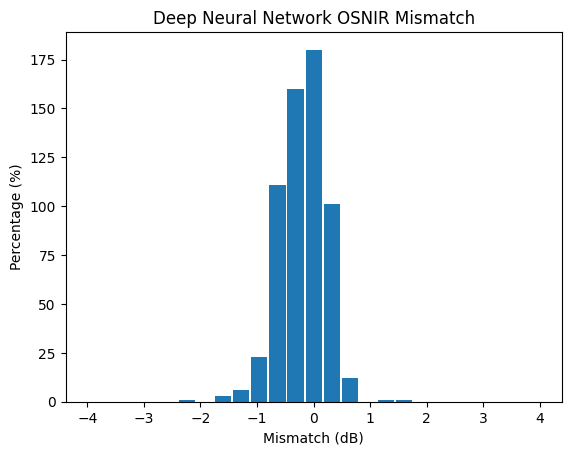

In [59]:
plt.title('Deep Neural Network OSNIR Mismatch')
plt.xlabel('Mismatch (dB)')
plt.ylabel('Percentage (%)')
plt.hist(pred_difference, range=(-4,4), rwidth=0.9, bins=25)